In [1]:
%pip install --upgrade uncertainties

Note: you may need to restart the kernel to use updated packages.


In [2]:
import caesar
import numpy as np
import astropy
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable, Table, Column
import matplotlib.pyplot as plt
import os
import scipy
from scipy import stats
import seaborn as sns
import uncertainties as unc  
import uncertainties.unumpy as unumpy
from scipy.stats import binned_statistic_2d
import matplotlib
import warnings
warnings.filterwarnings('ignore')

/home/sarah/anaconda3/lib/python3.9/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/sarah/.config/yt/ytrc is deprecated in favor of /home/sarah/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [3]:
def get_properties(obj):
    ''' 
    Returns the properties x-ray luminosities, stellar mass, star formation rate, specific star formation rate, 
    black hole mass, and lambda for every galaxy in the input file with stellar mass greater than 10^10 solar masses

        Parameters:
                obj : Caesar read infile
                      

        Returns:
                          Lx : array_like
                               An array of x-ray luminosities
                stellar_mass : array_like
                               An array of stellar masses
                         SFR : array_like
                               An array of star formation rates
                        sSFR : array_like
                               An array of specific star formation rates
                     bh_mass : array_like
                               An array of black hole masses
                       lmbda : array_like
                               An array of lambda
                        Ledd : array_like
                               An array of eddington accretion
    '''
    
    # get Lx
    # get an array of all bhmdot and bh_fedd
    accretion_rates = [i.bhmdot for i in obj.galaxies]
    eddington_ratio = [i.bh_fedd for i in obj.galaxies]

    # extract data into array
    bhmdot = np.array(accretion_rates)
    bh_fedd = np.array(eddington_ratio)
    
    # finding Ledd
    Ledd = bhmdot/bh_fedd
    
    # finding the bolometric luminosities
    # array with shape bhmdot of Lbols using the first equation (fedd > 0.1) for all values
    Er = 0.1
    Lbol = ((Er/(1-Er))*bhmdot*(u.M_sun/u.yr)*(const.c**2))
    
    # replacing the indices where fedd < 0.1 with values using the other equation
    # this retains the units
    Lbol[bh_fedd < 0.1] = (10*bh_fedd[bh_fedd < 0.1])*Er*bhmdot[bh_fedd < 0.1]*(u.M_sun/u.yr)*(const.c**2)
    
    # finds the bolometric correction
    BC = 10.83*((Lbol.to('L_sun')/(10**(10)*u.L_sun))**(0.28)) + 6.08*((Lbol.to('L_sun')/(10**(10)*u.L_sun))**(-0.02))
    
    # finding the hard x-ray luminosity in terms of Lsun
    # have to use just the value of Lbol_sun then add it back on because np.log10 only works on dimensionless quantities
    # it then converts to erg/s
    Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')
    
    #making it unitless
    Lx = Lx_ergs.value
    
    
    
    
    # extract galaxy mass data
    galaxy_masses = [i.masses['stellar'] for i in obj.galaxies]
    all_sm = np.array(galaxy_masses)
    sm_gt10 = (all_sm > 10**10)
    stellar_mass = all_sm[sm_gt10]
    
    # masking Lx for corresponding stellar masses > 10^10
    Lx = Lx[sm_gt10]
    
    # masking Ledd for corresponding stellar masses > 10^10
    Ledd = Ledd[sm_gt10]
    
    # masking fedd for corresponding stellar masses > 10^10
    bh_fedd = bh_fedd[sm_gt10]
    
    bhmdot = bhmdot[sm_gt10]
    
    # extract star formation rates data
    galaxy_SFRs = [i.sfr for i in obj.galaxies]
    SFR = np.array(galaxy_SFRs)
    SFR = SFR[sm_gt10]
    
    # extract black hole mass data
    bh_masses = [i.masses['bh'] for i in obj.galaxies]
    bh_mass = np.array(bh_masses)
    bh_mass = bh_mass[sm_gt10]
    
    # calculate specific star formation rate
    sSFR = SFR/stellar_mass
    
    # calculating lambda
    lmbda = 25.0*Lx / (1.3e38*0.002*stellar_mass)  
    
    
    return Lx, stellar_mass, SFR, sSFR, bh_mass, lmbda, Ledd, bh_fedd, bhmdot

In [4]:
# a list of the different redshifted files I want to load (box size 100)
files = ['m100n1024_056.hdf5',
'm100n1024_066.hdf5',
'm100n1024_074.hdf5',
'm100n1024_084.hdf5',
'm100n1024_097.hdf5',
'm100n1024_114.hdf5',
'm100n1024_137.hdf5']
files.reverse()

In [5]:
def get_all_r():
    # define input file
    # box 25
    #folder_path = '/disk04/rad/sim/m25n256/s50/Groups/' 
    #box 100
    folder_path = '/disk04/rad/sim/m100n1024/s50/Groups/'

    # empty dictionary to place redshift table data into
    all_r = {}

    for filename in files:
        # load in input file
        obj = caesar.load(os.path.join(folder_path, filename))

        # obtaining the properties
        Lx, sm, SFR, sSFR, bhm, lmbda, Ledd, fedd, BHAR = get_properties(obj)

        # finding the z label
        label = filename.split('m100n1024_')[1].split('.hdf5')[0]

        # creating a table for each redshift, putting it in the empty dictionary, and naming them
        name = str('z') + str(label)
        all_r[name] = astropy.table.Table([Lx, sm, SFR, sSFR, bhm, lmbda, Ledd, fedd, BHAR], 
                                          names=('Lx', 'sm', 'SFR', 'sSFR', 'bhm', 'lambda', 'Ledd', 'fedd', 'BHAR'))
        
    return all_r
    

    

In [6]:
def find_fracs(lambdas, Lx):
    '''
    Finds the percentage of galaxies with lambda greater than 0.01 and 0.1 AND Lx greater than 10^42 for a given set 
    of galaxies defined by their input log lambdas.
    
    Parameters:
                lambdas : array_like
                          An array of log(lambdas)
                      

        Returns:
                frac_gt2 : float
                           The percentage of galaxies with lambda greater than 0.01 AND Lx greater than 10^42
                frac_gt1 : float
                           The percentage of galaxies with lambda greater than 0.1 AND Lx greater than 10^42
                           
    
    '''
    mask2 = (lambdas > -2) & (Lx > 1e42)
    l_gr2 = lambdas[mask2]
            
    if len(l_gr2) == 0:
        #print('there are no lambdas>0.01')
        frac_gt2 = float('NaN')
    else:
        frac_gt2 = (len(l_gr2)/len(lambdas))*100

    mask1 = (lambdas > -1) & (Lx > 1e42)
    l_gr1 = lambdas[mask1]

    if len(l_gr1) == 0:
        #print('there are no lambdas>0.1')
        frac_gt1 = float('Nan')
    else:
        frac_gt1 = (len(l_gr1)/len(lambdas))*100

    #print(frac_gt2)
    #print(frac_gt1)
    
    return frac_gt2, frac_gt1

In [7]:
#0.01
z = [0.25, 0.75, 1.25, 1.75, 2.25]
jSFR_bins = np.reshape(np.flip(np.array([2.525, 1.98, 1.289, 0.32, -0.703, 2.126, 1.739, 0.98, -0.017, 
          -1.022, 1.833, 1.433, 0.703, -0.378, -1.519, 1.564, 1.088, 0.467, 
          -0.716, -1.932, 1.196, 0.651, 0.08, -0.884, -2.636])), (5,5))
jAGN_fracs_gt2 = np.reshape(np.flip(np.array([23.992, 12.484, 23.354, 13.015, 10.793, 9.974, 10.638,
         16.218, 8.192, 4.12, 9.142, 6.743, 13.323, 4.89, 2.501,
         5.931, 3.617, 5.843, 1.469, 0.934, 3.525, 1.153, 0.696,
         0.418, 0.218])), (5,5))
#0.1
jAGN_fracs_gt1 = np.reshape(np.flip(np.array([13.02, 2.62, 7.133, 3.277, 1.071, 2.87, 1.598, 3.611, 1.349,
          0.4, 2.335, 1.025, 1.635, 0.414, 0.144, 1.48, 0.249, 0.387,
          0.148, 0.025, 0.905, 0.056, 0.046, 0.085, 0.027])), (5,5))

lo_err_gt1 = np.array([2.505, 0.336, 1.089, 0.895, 0.407, 0.445, 0.166, 0.477, 0.283, 0.128, 0.337,
                       0.099, 0.271, 0.109, 0.053, 0.294, 0.037, 0.089, 0.05, 0.014, 0.417, 0.03,
                       0.03, 0.054, 0.018])
hi_err_gt1 = np.array([2.631, 0.392, 1.26, 1.091, 0.57, 0.508, 0.17, 0.57, 0.316, 0.183, 0.389, 0.103,
                       0.318, 0.135, 0.074, 0.368, 0.045, 0.12, 0.077, 0.027, 0.754, 0.053, 0.068,
                       0.144, 0.048])



lo_err_gt2 = np.array([3.788, 1.278, 2.644, 2.957, 2.586, 1.641, 0.796, 1.69, 1.202, 0.843, 1.242,
                       0.381, 1.063, 0.678, 0.423, 0.814, 0.214, 0.492, 0.277, 0.169, 1.189, 0.208,
                       0.196, 0.182, 0.082])
hi_err_gt2 = np.array([4.416, 1.335, 2.808, 3.261, 3.153, 1.675, 0.784, 1.791, 1.245, 0.947, 1.379,
                       0.402, 1.124, 0.788, 0.501, 0.897, 0.218, 0.492, 0.327, 0.198, 1.544, 0.229,
                       0.25, 0.284,0.125])


lo_err_gt1 = np.flip(lo_err_gt1)
lo_err_gt2 = np.flip(lo_err_gt2)

hi_err_gt1 = np.flip(hi_err_gt1)
hi_err_gt2 = np.flip(hi_err_gt2)
#print(np.split(lo_err_gt1, 5))

lo_err_gt1 = np.split(lo_err_gt1, 5)
lo_err_gt2 = np.split(lo_err_gt2, 5)

hi_err_gt1 = np.split(hi_err_gt1, 5)
hi_err_gt2 = np.split(hi_err_gt2, 5)

err_bounds_allz = []
lo_bounds_allz = []
up_bounds_allz = []
for z in range(len(jAGN_fracs_gt2)):
    jfracs2_lo = unumpy.uarray((jAGN_fracs_gt2[z], lo_err_gt2[z]))  
    jfracs1_lo = unumpy.uarray((jAGN_fracs_gt1[z], lo_err_gt1[z]))
    vari_lo = jfracs1_lo/jfracs2_lo
    prop_err_lo = unumpy.std_devs(vari_lo)

    jfracs2_hi = unumpy.uarray((jAGN_fracs_gt2[z], hi_err_gt2[z]))  
    jfracs1_hi = unumpy.uarray((jAGN_fracs_gt1[z], hi_err_gt1[z]))
    vari_hi = jfracs1_hi/jfracs2_hi
    prop_err_hi = unumpy.std_devs(vari_hi)

    err_bounds = np.vstack((prop_err_lo,prop_err_hi))
    
    lo_bounds = jAGN_fracs_gt1[z]/jAGN_fracs_gt2[z] - err_bounds[0]
    up_bounds = jAGN_fracs_gt1[z]/jAGN_fracs_gt2[z] + err_bounds[1]
    
    err_bounds_allz.append(err_bounds)
    lo_bounds_allz.append(lo_bounds)
    up_bounds_allz.append(up_bounds)

In [8]:
all_r = get_all_r()
#print(all_r)

yt : [INFO     ] 2023-03-19 16:10:45,041 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_137.hdf5
yt : [INFO     ] 2023-03-19 16:10:45,105 Found 482650 halos
yt : [INFO     ] 2023-03-19 16:10:45,115 Found 49752 galaxies
yt : [INFO     ] 2023-03-19 16:10:47,911 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_114.hdf5
yt : [INFO     ] 2023-03-19 16:10:47,943 Found 517907 halos
yt : [INFO     ] 2023-03-19 16:10:47,952 Found 41585 galaxies
yt : [INFO     ] 2023-03-19 16:10:50,102 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_097.hdf5
yt : [INFO     ] 2023-03-19 16:10:50,135 Found 539783 halos
yt : [INFO     ] 2023-03-19 16:10:50,143 Found 37280 galaxies
yt : [INFO     ] 2023-03-19 16:10:52,487 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_084.hdf5
yt : [INFO     ] 2023-03-19 16:10:52,516 Found 547198 halos
yt : [INFO     ] 2023-03-19 16:10:52,524 Found 33282 galaxies
yt : [INFO     ] 2023-03-19 16:10:54,396 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1

In [9]:

def prob_dists(sigma):
    
        #all_r = get_all_r()
        z = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.5]

        # lists to store the 6 agn fractions (each redshift)
        #AGN_fracs_gt2 = []
        #AGN_fracs_gt1 = []
        p_lams = np.array([])

        # list to store the 6 sfr bin midpoints for plotting
        #SFR_bins = []

        #iterating across each redshift
        for count, key in enumerate(all_r):

            #
            #AGN_frac_per_bin_gt2 = np.array([])
            #AGN_frac_per_bin_gt1 = np.array([])
            p_lam_per_bin = []

            #extract xray luminosities to make mask Lx> 10^42
            Lx = all_r[key]['Lx'].copy()

            no_zeros = (Lx!=0)

            Lx = Lx[no_zeros]

            sm = all_r[key]['sm'][no_zeros].copy()
            logsm = np.log10(sm.data)

            # NEW WAY: binning the mass data
            #extracting the sfrs for this redshift
            SFRs_all = all_r[key]['SFR'][no_zeros].copy()
            SFRs = SFRs_all

            #creating an empty array with the size equal to the amount of 0 sfr values
            rand_sams = np.zeros(SFRs[SFRs == 0].shape)

            #filling the empty array with random numbers ranging between 0.000001 and 0.00001
            for i in range(len(rand_sams)):
                rand_sams[i] = np.random.uniform(1e-3, 1e-2)

            #replacing 0 sfr values with the randomly sampled low values
            SFRs[SFRs == 0] = rand_sams

            #logging the full sfr array with 0 values replaced
            logSFRs = np.log10(np.asarray(SFRs))

            #calculating relative MS values
            logSFR_MS = logSFRs + 7.6 - 0.76*logsm - 2.95*np.log10(1+z[count])

            #defining bin boundaries
            bins = [np.inf, 0.15, -0.4, -0.95, -np.inf]

            #binning data based on relative MS values
            digitized = np.digitize(logSFR_MS, bins)

            # finding plotting points
            #SFRs_midpoints = np.array([])

            # iterating across each bin
            for i in range(1, len(bins)):
                # finding the lambdas in a certain bin
                lmbda = all_r[key]['lambda'][no_zeros].copy()
                lambdas = np.log10(lmbda[digitized == i])
                lambdas = lambdas.tolist()
                #plt.hist(lambdas, bins=100)
                #plt.show()


                '''        
                #ADDING SCATTER
                '''
                #mu = np.mean(lambdas)
                #sigma = sigma

                #print('loglams:', lambdas)
                #print('mean:', mu)
                #print('stdev:', sigma)

                #print(lambdas.size)
                #np.random.seed(999)
                #new_lambdas = lambdas + np.random.normal(0, sigma, lambdas.size)
                #new_lambdas = np.random.poisson(mu, lambdas.size)


                # finding the Lxs in a certain bin
                Lx_binned = Lx[digitized == i]
                # finding the agn fractions (2) for a certain bin
                #frac_gt2, frac_gt1 = find_fracs(new_lambdas, Lx_binned)

                #binning sfrs
                #sfr_binned = logSFRs[digitized == i]
                #SFRs_midpoints = np.append(SFRs_midpoints, np.median(sfr_binned))

                #adding the agn fraction of each bin to an array length 5 (no of bins)
                #AGN_frac_per_bin_gt2 = np.append(AGN_frac_per_bin_gt2, frac_gt2)
                #AGN_frac_per_bin_gt1 = np.append(AGN_frac_per_bin_gt1, frac_gt1)
                p_lam_per_bin.append(lambdas)

            p_lam_per_bin = np.asarray(p_lam_per_bin, dtype=object)
            #print(p_lam_per_bin)
            #SFR_bins.append(SFRs_midpoints)
            # adding the certain redshifts agn fraction for each bin, into an array length 6 (no of redshifts)
            #AGN_fracs_gt2.append(AGN_frac_per_bin_gt2)
            #AGN_fracs_gt1.append(AGN_frac_per_bin_gt1)
            if count==0:
                p_lams = p_lam_per_bin
            else:
                p_lams = np.vstack((p_lams, p_lam_per_bin))
            
            #this might not work becayse the redshift lists are different lengths
            #fracs2 = np.array(AGN_fracs_gt2)
            #fracs1 = np.array(AGN_fracs_gt1)
            
            #variations = fracs1/fracs2
            #print(variations)
            
        return p_lams

In [10]:
z = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.5]

logSFR_MS_list = []
logsm_list = []
loglambda_list = []
logLx_list = []

for i, key in enumerate(all_r):  
    # creating the masks to bin the stellar masses
    # there should be no galaxies greater than 10^11.5 so the upper most bin is just > 10^11
    sm = all_r[key]['sm']

    SFR = all_r[key]['SFR']
    
    lmbda = all_r[key]['lambda']
    
    Lx = all_r[key]['Lx']
    
    logSFR = np.log10(SFR[SFR != 0].data)

    logsm = np.log10(sm[SFR != 0].data)
    
    loglambda = np.log10(lmbda[SFR != 0].data)
    
    logLx = np.log10(Lx[SFR != 0].data)
    
    logSFR_MS = logSFR + 7.6 - 0.76*logsm - 2.95*np.log10(1+z[i])
    
    logSFR_MS_list.append(logSFR_MS)
    logsm_list.append(logsm)
    loglambda_list.append(loglambda)
    logLx_list.append(logLx)

In [11]:
logsm_all = np.concatenate(logsm_list)
logSFR_MS_list = np.concatenate(logSFR_MS_list)
loglambda_list = np.concatenate(loglambda_list)
logLx_list = np.concatenate(logLx_list)

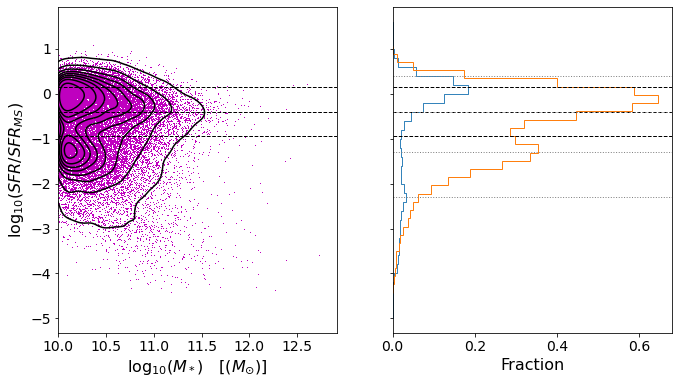

In [25]:


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey='all', figsize=(11,6))

ax1.plot(logsm_all, logSFR_MS_list,  'm,')
sns.kdeplot(logsm_all, logSFR_MS_list, color='k', ax = ax1, linewidth=0.1)
ax1.set_xlim(left=10)
ax1.axhline((0.15), color='k', linestyle='dashed', linewidth=1)
ax1.axhline((-0.4), color='k', linestyle='dashed', linewidth=1)
ax1.axhline((-0.95), color='k', linestyle='dashed', linewidth=1)
#ax1.axhline((-2.3), color='k', linestyle='dashed', linewidth=1)
#ax1.axhline((-1.25 + 0.3*0.25), color='r', linestyle='dashed', linewidth=1)
ax1.set_xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$', fontsize=16)
ax1.set_ylabel('$\log_{10}(SFR/SFR_{MS})$' , fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2.step(dists['fgal'], dists['logsfr_ms'], linewidth=0.9, label='Aird et al. 2019')
ax2.hist(logSFR_MS_list, bins=30, orientation='horizontal', histtype='step', density=True, label='Simba')
ax2.axhline((0.15), color='k', linestyle='dashed', linewidth=1)
ax2.axhline((-0.4), color='k', linestyle='dashed', linewidth=1)
ax2.axhline((-0.95), color='k', linestyle='dashed', linewidth=1)
#ax2.axhline((-2.3), color='k', linestyle='dashed', linewidth=1)
ax2.set_xlabel('Fraction' , fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)


ax2.axhline((0.4), color='grey', linestyle=':', linewidth=1)
ax2.axhline((-0.4), color='grey', linestyle=':', linewidth=1)
ax2.axhline((-1.3), color='grey', linestyle=':', linewidth=1)
ax2.axhline((-2.3), color='grey', linestyle=':', linewidth=1)

#ax2.axhline((-1.25 + 0.3*0.25), color='r', linestyle='dashed', linewidth=1, label='sf-qu cut-off')
#fig.legend()

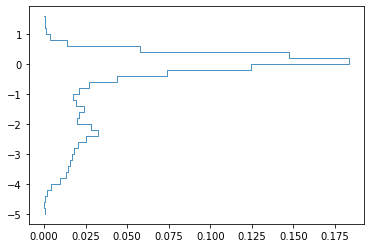

In [19]:
file = open('Aird19_fig8_histograms.dat')

#turning the data into an astropy table
dists = astropy.table.Table(np.loadtxt(file), names=['logsfr_ms', 'fgal', 'fx'])
#print(dists)

plt.step(dists['fgal'], dists['logsfr_ms'], linewidth=0.8)

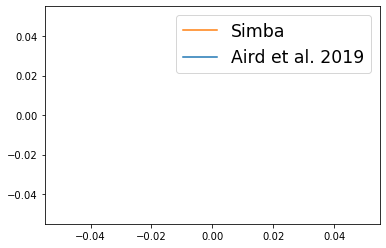

In [28]:
fig, ax = plt.subplots()
ax.plot(0,0, label='Aird et al. 2019')
ax.plot(0,0, label='Simba')

handles, labels = ax.get_legend_handles_labels()

plt.legend(reversed(handles), reversed(labels), fontsize='xx-large')
plt.show()

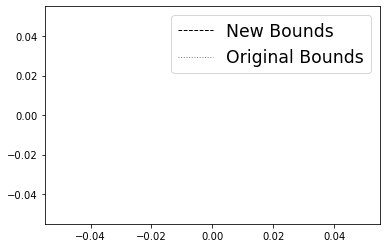

In [29]:
plt.plot(0,0, color='k', linestyle='dashed', linewidth=1, label='New Bounds')
plt.plot(0,0, color='grey', linestyle=':', linewidth=1, label='Original Bounds')
plt.legend(fontsize='xx-large')
plt.show()